# Predicción Abundancias Networld

*$\beta$ AS PRDICTOR*

---

## Setup

In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

from matplotlib.colors import Colormap

In [2]:
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso, BayesianRidge
from sklearn.svm import SVR
from sklearn.compose import ColumnTransformer
from scipy.stats import entropy, gaussian_kde, pearsonr

In [3]:
from statsmodels.gam.api import BSplines
from statsmodels.gam.api import GLMGam


In [3]:
data_path = '../data/Networld_N200_TMax10000/'

In [5]:
betas = [0.001,0.0015849,0.0025119,0.0039811,0.0063096,
         0.01,0.015849,0.025119,0.039811,0.063096,
         0.1,0.15849,0.25119,0.39811,0.63096,
         1, 1.5849, 2.5119, 3.9811, 6.3096]

data = [pd.read_csv(data_path + f'ABD_MEA_N200_K5_Beta{beta}.csv') 
        for beta in betas]
data = pd.concat(data)

data['log(Size)'] = np.log10(data['Size'])
data['log(Ab)'] = np.log10(data['Ab'])
data['log(beta)'] = np.log10(data['beta'])

data.head()

,NRed,Ab,beta,Size,Lambda1,Lambda2,mu,Gr_Medio,H,log(Size),log(Ab),log(beta)
0,1,0.990503,0.001000,1,0.000000,0.0,0.0,0.000000,0.000000,0.000000,-0.004144,-3.000000
1,2,0.009488,0.001000,2,1.000000,1.0,2.0,1.000000,0.000000,0.301030,-2.022825,-3.000000
2,30,0.000009,0.001000,3,1.414214,0.0,1.0,1.333333,0.918296,0.477121,-5.068181,-3.000000
0,1,0.985471,0.001585,1,0.000000,0.0,0.0,0.000000,0.000000,0.000000,-0.006356,-2.799998
1,2,0.014508,0.001585,2,1.000000,1.0,2.0,1.000000,0.000000,0.301030,-1.838395,-2.799998


Top 30 redes más pequeñas para gráficas donde no se pueden incluir todas las redes

In [6]:
small_nets = data[['NRed','Size']].drop_duplicates()
small_nets = small_nets.sort_values(by='Size', ascending=True)
small_nets = small_nets.head(10)['NRed']

small_nets = data.loc[data['NRed'].isin(small_nets)]

## Análisis exploratorio

### Distribuciones univariadas

***Variable Target***

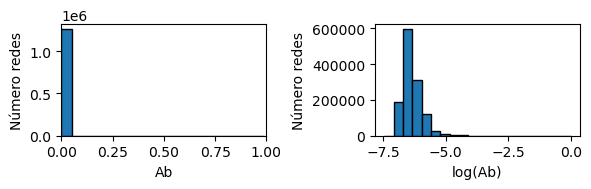

In [7]:
fig, axs = plt.subplots(1,2, figsize=(6,2))

data['Ab'].plot.hist(bins=20, edgecolor='black', ax=axs[0])
axs[0].set_xlim([0,1])
axs[0].set_xlabel('Ab')
axs[0].set_ylabel('Número redes')

data['log(Ab)'].plot.hist(bins=20, edgecolor='black', ax=axs[1])
axs[1].set_xlabel('log(Ab)')
axs[1].set_ylabel('Número redes')

fig.tight_layout()

Las abundancias claramente se deberán tratar en términos logarítmicos (o de forma similar como en una función logística) porque en términos absolutos habría un desequilibrio masivo de los datos.

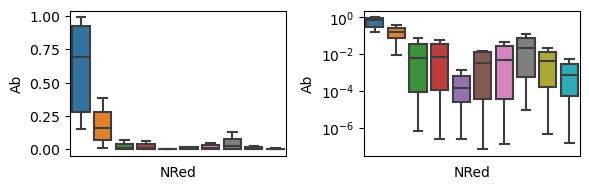

In [8]:
fig, axs = plt.subplots(1,2, figsize=(6,2))
sn.boxplot(data=small_nets, y='Ab', x='NRed', ax=axs[0])
axs[0].set_xlabel('NRed')
axs[0].set_xticks([])

sn.boxplot(data=small_nets, y='Ab', x='NRed', ax=axs[1])
axs[1].set_xlabel('NRed')
axs[1].set_yscale('log')
axs[1].set_xticks([])

fig.tight_layout()

Esta gráfica demuestra que es necesario contar con $\beta$ para predecir las abundancias, ya que de lo contrario los rangos de variación son descomunales.

***Variables predictoras*** (A nivel de conjunto de redes)

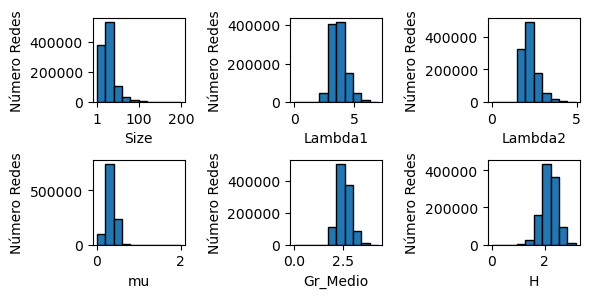

In [9]:
measures = data[['NRed','Size','Lambda1','Lambda2','mu','Gr_Medio','H']].drop_duplicates(subset='NRed')
xticks = [[1,100,200],
          None,None,None,None,None]

fig, axs = plt.subplots(2,3,figsize=(6,3))
axlist = [ax for axl in axs for ax in axl]
for i,col in enumerate(measures.columns[1:]):
    measures[col].plot.hist(ax=axlist[i], edgecolor='black')
    axlist[i].set_xlabel(col)
    if xticks[i] is not None:
        axlist[i].set_xticks(xticks[i])
    axlist[i].set_ylabel('Número Redes')

fig.tight_layout()

Algunas variables parecen ser aproximadamente normales, y otras parecen seguir una gamma.

El número de redes de cierto tamaño crece siempre de acuerdo a una "exponencial?". El decrecimiento en el número observado se debe a que el sistema no tiene tiempo / oportunidad para formarlas todas

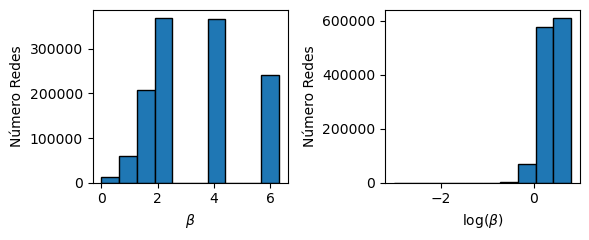

In [10]:
fig, axs = plt.subplots(1,2,figsize=(6,2.5))
data['beta'].plot.hist(ax=axs[0], edgecolor='black')
axs[0].set_xlabel(r'$\beta$')
axs[0].set_ylabel('Número Redes')
data['log(beta)'].plot.hist(ax=axs[1], edgecolor='black')
axs[1].set_xlabel(r'log($\beta$)')
axs[1].set_ylabel('Número Redes')

fig.tight_layout()

Equivalente al número de configuraciones en función de $\beta$ (aquí se ve peor). En cualquier caso muestra como hay más redes con abundancia para betas altas (irrelevante ya que se incluirán posteriormente todas las redes en todas las betas).

Text(0, 0.5, 'Número Redes')

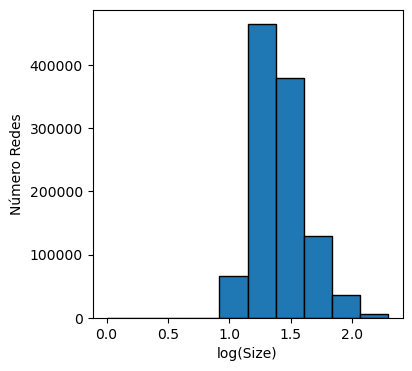

In [11]:
plt.figure(figsize=(4,4))
np.log10(measures['Size']).plot.hist(edgecolor='black')
plt.xlabel('log(Size)')
plt.ylabel('Número Redes')

El logaritmo del tamaño parece un espacio mucho más razonable para esta variable así que en general se mirará así

***Variables predictoras*** (A nivel de ocurrencias)

En vez de comprobar cuantas redes del conjunto identificado tienen ciertos valores, vemos cuantos puntos de datos los tienen. Es prácticamente idéntico.

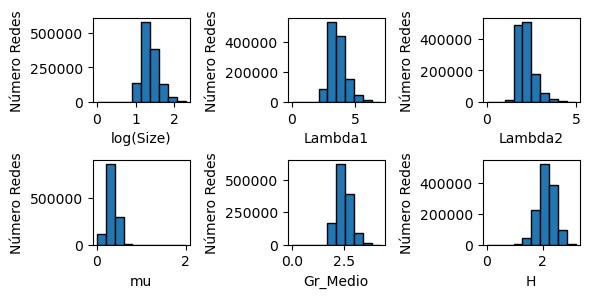

In [29]:
measures = data[['NRed','log(Size)','Lambda1','Lambda2','mu','Gr_Medio','H']]
xticks = [[0,1,2],
          None,None,None,None,None]

fig, axs = plt.subplots(2,3,figsize=(6,3))
axlist = [ax for axl in axs for ax in axl]
for i,col in enumerate(measures.columns[1:]):
    measures[col].plot.hist(ax=axlist[i], edgecolor='black')
    axlist[i].set_xlabel(col)
    if xticks[i] is not None:
        axlist[i].set_xticks(xticks[i])
    axlist[i].set_ylabel('Número Redes')

fig.tight_layout()

### Distribuciones bivariadas

***Variable predictora - target***

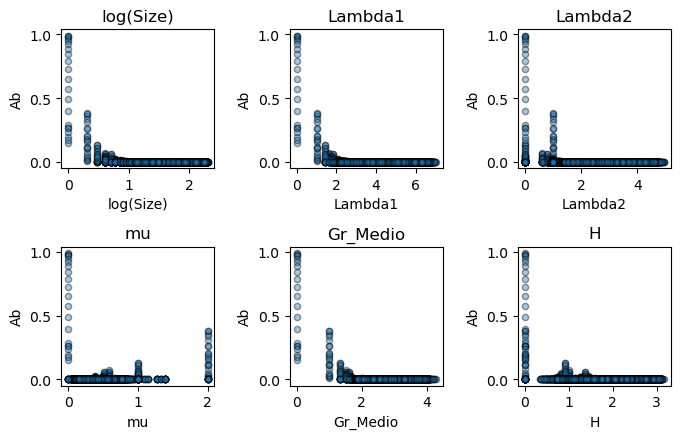

In [30]:
fig, axs = plt.subplots(2,3,figsize=(7,4.5))
axlist = [ax for axl in axs for ax in axl]

meas_columns = ['log(Size)','Lambda1','Lambda2','mu','Gr_Medio','H']
for i, col in enumerate(meas_columns):
    data.plot.scatter(x=col, y='Ab', alpha=0.4, edgecolor='black', ax=axlist[i])
    axlist[i].set_title(col)
    axlist[i].locator_params(axis='x', nbins=4)
fig.tight_layout()

Las variables predictoras no parecen muy informativas sobre la abundancia lineal

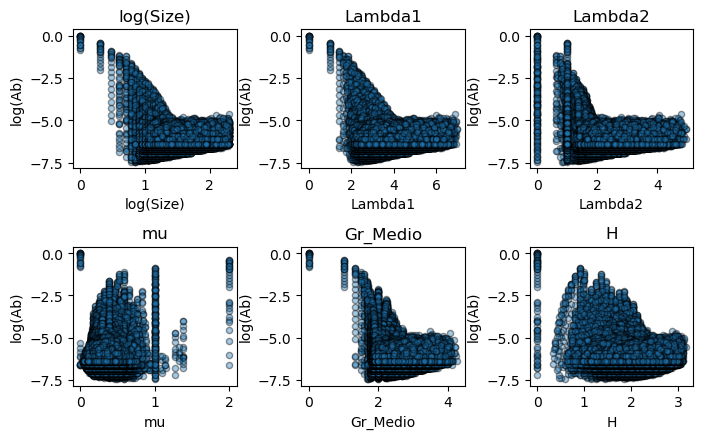

In [12]:
fig, axs = plt.subplots(2,3,figsize=(7,4.5))
axlist = [ax for axl in axs for ax in axl]

meas_columns = ['log(Size)','Lambda1','Lambda2','mu','Gr_Medio','H']
for i, col in enumerate(meas_columns):
    data.plot.scatter(x=col, y='log(Ab)', alpha=0.4, edgecolor='black', ax=axlist[i])
    axlist[i].set_title(col)
    axlist[i].locator_params(axis='x', nbins=4)
fig.tight_layout()

Sobre la abundancia logarítmica se aprecia algo más de información. Algunas medidas como Size, Lambdas o GrMedio tienen abundancias muy bajas para sus valores extremos (pero este comportamiento en general debería desaparecer con $\beta$ mayor).

En cualquier caso parece claro que en ausencia de una $\beta$ no hay correlaciones apreciables. 

Aun así se repite la figura del tamaño con límite a ~20 para comprobar el comportamiento con las redes más pequeñas

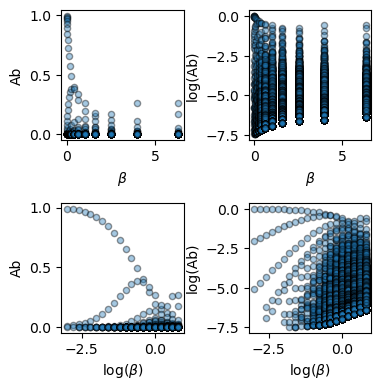

In [13]:
fig, axs = plt.subplots(2,2,figsize=(4,4))

data.plot.scatter(x='beta', y='Ab', alpha=0.4, edgecolor='black', ax=axs[0][0])
axs[0][0].set_xlabel(r'$\beta$')
data.plot.scatter(x='beta', y='log(Ab)', alpha=0.4, edgecolor='black', ax=axs[0][1])
axs[0][1].set_xlabel(r'$\beta$')
data.plot.scatter(x='log(beta)', y='Ab', alpha=0.4, edgecolor='black', ax=axs[1][0])
axs[1][0].set_xlabel(r'log($\beta$)')
data.plot.scatter(x='log(beta)', y='log(Ab)', alpha=0.4, edgecolor='black', ax=axs[1][1])
axs[1][1].set_xlabel(r'log($\beta$)')

fig.tight_layout()

Obviamente, $\beta$ por si sola tampoco determina la abundancia en ninguna escala. Para cualquier beta hay una gran diversidad de abundancias.

***Figura 3A - PNAS***

Text(0.5, 0, '$\\beta$')

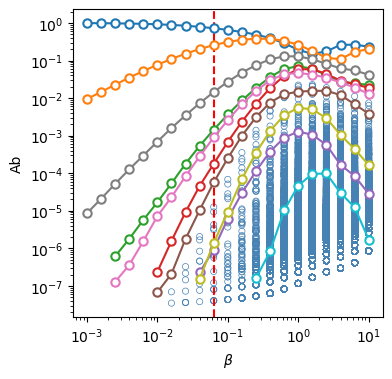

In [15]:
fig, ax = plt.subplots(figsize=(4,4))
ax.axvline(x=10**(-1.2), ls='--', color='red')
data.plot.scatter(x='beta', y='Ab', ax=ax, edgecolor='steelblue', c='none', linewidths=0.5)
pivot_data = pd.pivot_table(data=small_nets, index='beta', columns='NRed', values='Ab')
pivot_data.plot(style='-o',markerfacecolor='white', markeredgewidth=1.5, legend=False, ax=ax)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\beta$')

***Figura 3C - PNAS***

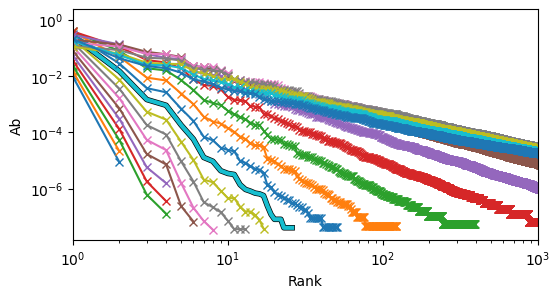

In [16]:
fig, ax = plt.subplots(figsize=(6,3))
for beta in betas:
    beta_ab = data.loc[data['beta'] == beta]
    beta_ab = beta_ab.sort_values(by='Ab', ascending=False)
    if beta == 0.063096:
        ax.plot(beta_ab['Ab'].values, '-', linewidth=4, color='black')
        ax.plot(beta_ab['Ab'].values, '-', linewidth=3)
    else:
        ax.plot(beta_ab['Ab'].values, '-x')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(1,1000)
    plt.xlabel('Rank')
    plt.ylabel('Ab')

***Variables predictoras - predictoras***

In [35]:
measure_table = measures[meas_columns].reset_index(drop=True)

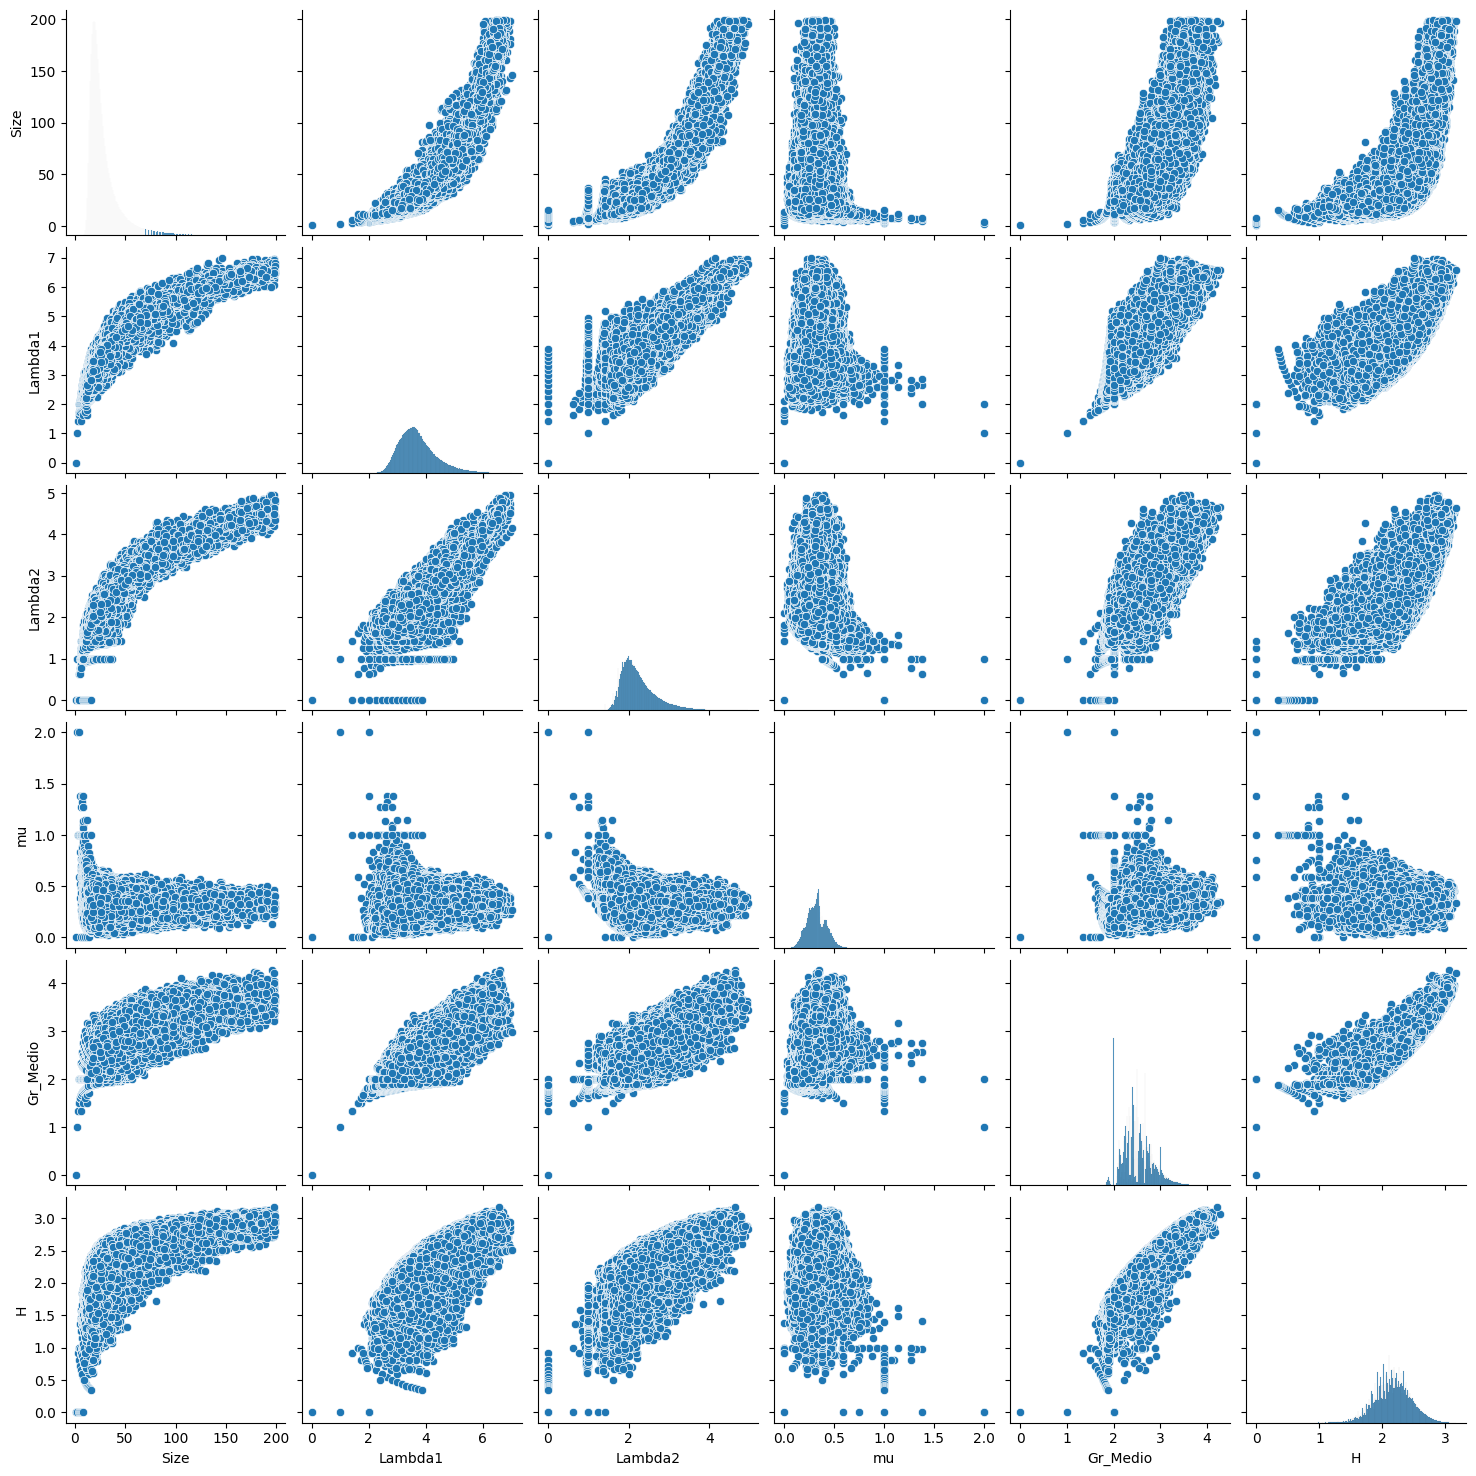

In [47]:
sn.pairplot(measure_table)

Se encuentran en general correlaciones importantes entre las variables (Lambda1 y La,bda2, Lambda1 y H, Gr_Medio y H). Esta información se resume mejor mediante la matriz de correlación.

De todas formas algunas correlaciones parecen tener un carácter logarítmico (Size con algunas de las anteriores).

Mu es la única medida que no está correlacionada con las demás.

<AxesSubplot:>

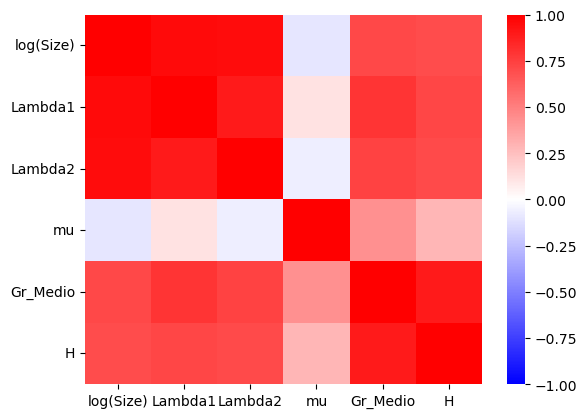

In [37]:
sn.heatmap(measure_table.corr(), cmap='bwr', vmin=-1,vmax=1)

Confirmamos las altísimas correlaciones entre variables (incluso si la relación real en algunos casos tiene carácter logarítmico) y que la única variable que es algo independiente es $\mu$.

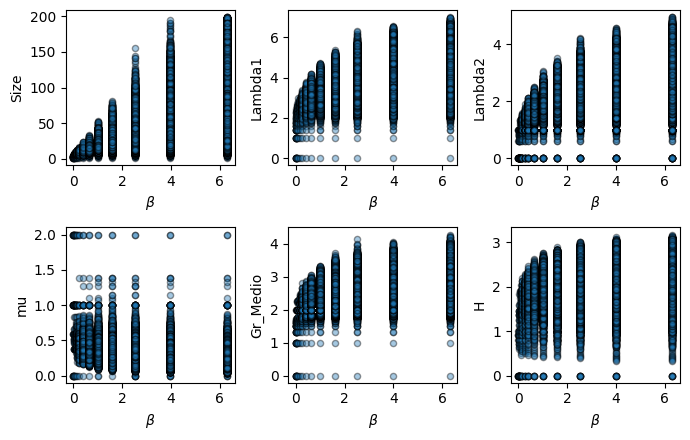

In [10]:
fig, axs = plt.subplots(2,3,figsize=(7,4.5))
axlist = [ax for axl in axs for ax in axl]

for i,col in enumerate(meas_columns):
    data.plot.scatter(x='beta', y=col, ax=axlist[i], alpha=0.4, edgecolor='black')
    axlist[i].set_xlabel(r'$\beta$')

fig.tight_layout()

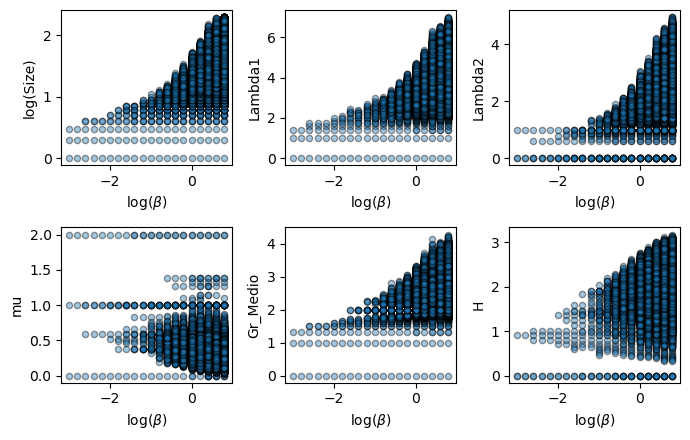

In [14]:
fig, axs = plt.subplots(2,3,figsize=(7,4.5))
axlist = [ax for axl in axs for ax in axl]

for i,col in enumerate(meas_columns):
    if col == 'Size':
        col = 'log(Size)'
    data.plot.scatter(x='log(beta)', y=col, ax=axlist[i], alpha=0.4, edgecolor='black')
    axlist[i].set_xlabel(r'log($\beta$)')

fig.tight_layout()

De nuevo ocurre que aunque no hay correlaciones en sentido estricto, si comprobamos que con $\beta$ mas altos aparecen redes más grandes, y en general mayores valores para varias medidas.

Cuando se incluyan todas las redes para todas las $\beta$ desaparecerá este efecto, pero de momento se puede usar como proxy para las abundancias de las redes en función de ambos parámetros de forma simultánea.

### Predictibilidad conjunta

En base a los resultados anteriores se puede intuir que habrá muy poca predictibilidad incluso al considerar $\beta$ si se la maneja como una variable más sin una consideración especial.

Dicho eso, parece apropiado al menos comprobar utilizando la siguiente combinación de varialbles:

$Ab = f(Size, \mu, \beta)$

Además, antes de intentar estimar la predictibilidad con una combinación de 3 parámetros (algo complicado), se intentará a hacerlo con los pares de Size + $\beta$ y $\mu$ + $\beta$

In [15]:
def compute_entropy(sample):
    if len(sample.unique()) > 1:
        kernel = gaussian_kde(sample)
        positions = np.linspace(-10,0,2000)
        densities = kernel(positions)
        return entropy(densities)
    else:
        return 0

***Distribución Size + $\beta$***


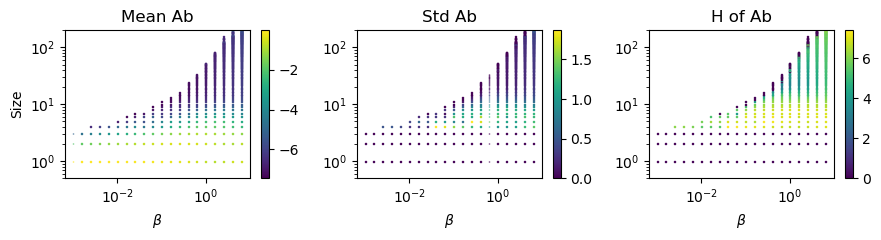

In [16]:
mean_ab = data.groupby(['Size','beta'])['log(Ab)'].mean().reset_index()
std_ab = data.groupby(['Size','beta'])['log(Ab)'].std().fillna(0).reset_index()
h_ab = data.groupby(['Size','beta'])['log(Ab)'].agg(compute_entropy).fillna(0).reset_index()

fig, axs = plt.subplots(1,3,figsize=(9,2.5))
im1 = axs[0].scatter(x=mean_ab['beta'], y=mean_ab['Size'], c=mean_ab['log(Ab)'], s=0.5, marker='s')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel(r'$\beta$')
axs[0].set_ylabel('Size')
axs[0].set_ylim(0.5,200)
axs[0].set_title('Mean Ab')
fig.colorbar(im1, ax=axs[0])
im2 = axs[1].scatter(x=std_ab['beta'], y=std_ab['Size'], c=std_ab['log(Ab)'], s=0.5, marker='s')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel(r'$\beta$')
axs[1].set_ylim(0.5,200)
axs[1].set_title('Std Ab')
fig.colorbar(im2, ax=axs[1])
im3 = axs[2].scatter(x=h_ab['beta'], y=h_ab['Size'], c=h_ab['log(Ab)'], s=0.5, marker='s')
axs[2].set_xscale('log')
axs[2].set_yscale('log')
axs[2].set_xlabel(r'$\beta$')
axs[2].set_ylim(0.5,200)
axs[2].set_title('H of Ab')
fig.colorbar(im3, ax=axs[2])

fig.tight_layout()

Esta figura es una de las mejores aproximaciones (que he conseguido obtener) a la predictibilidad de la abundancia según el tamaño y la $\beta$. 

Comprobamos que las redes más grandes para una cierta $\beta$ tienden a tener abundancias relativamente consistentes (desviaciones bajas en logaritmo), pero hay una región muy amplia donde la dispersión es muy grande y hay poca predictibilidad.

Para varios $\beta$, redes con el mismo tamaño tienen abundancias muy diferentes.

In [41]:
y = data['log(Ab)']

abmin, abmax = y.min(),y.max()

abs = np.random.uniform(low=abmin, high=abmax, size=(1000,1))

ts_indexes = []
for ab in abs:
    ts_indexes.append(np.argmin((data['log(Ab)'] - ab).abs()))

In [42]:
abs = np.random.uniform(low=abmin, high=abmax, size=(10000,1))

tr_indexes = []
for ab in abs:
    tr_indexes.append(np.argmin((data['log(Ab)'] - ab).abs()))

In [43]:
X = data[['log(Size)','log(beta)']]
X = (X - X.mean()) / X.std()

Xtest = X.iloc[ts_indexes]
ytest = y.iloc[ts_indexes]

Xtrain = X.iloc[tr_indexes]
ytrain = y.iloc[tr_indexes]

del X

In [44]:
ypreds = []
gamma = 1.06*500000**(-1/5)
gamma = 1/gamma

for i in range(len(Xtest)):
    Xdata = Xtest.iloc[i:i+1]
    kernel = rbf_kernel(Xdata, Xtrain, gamma=gamma)[0]
    norm = kernel.sum()
    ypred = (kernel*ytrain).sum() / norm
    ypreds.append(ypred)

ypreds = np.array(ypreds)

/home/mmartinez/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(-7, -2.5, 'R² = 0.951')

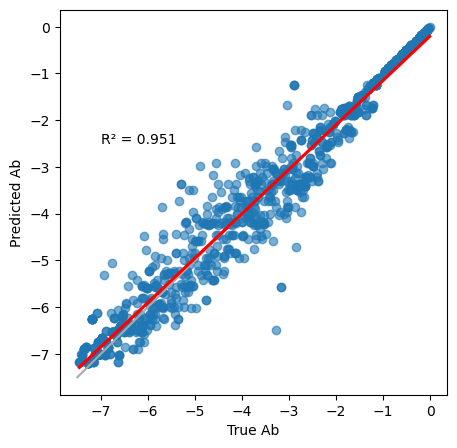

In [45]:
plt.figure(figsize=(5,5))

diag = np.linspace(-7.5,-4,1000)
plt.plot(diag, diag, '-', color='darkgrey')
sn.regplot(ytest, ypreds, line_kws=dict(color='red'), scatter_kws=dict(alpha=0.6))
#plt.xlim(-7.5,-4)
#plt.ylim(-7.5,-4)
plt.ylabel('Predicted Ab')
plt.xlabel('True Ab')
plt.annotate(f'R² = {round(r2_score(ytest, ypreds),3)}', (-7,-2.5))


***Distribución $\mu$ + $\beta$***

In [19]:
data['mu_disc'] = pd.cut(data['mu'], 100).apply(lambda x: x.mid)

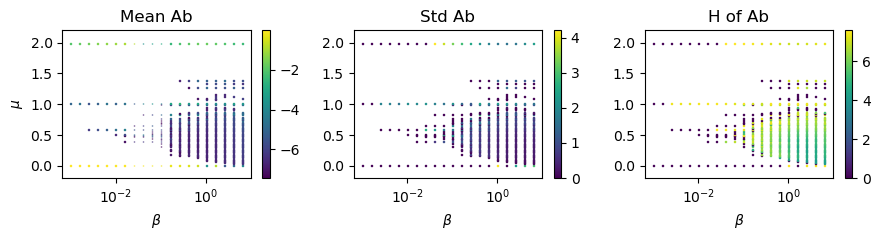

In [20]:
mean_ab = data.groupby(['mu_disc','beta'])['log(Ab)'].mean().reset_index()
std_ab = data.groupby(['mu_disc','beta'], observed=True)['log(Ab)'].std().fillna(0).reset_index()
h_ab = data.groupby(['mu_disc','beta'], observed=True)['log(Ab)'].agg(compute_entropy).fillna(0).reset_index()

fig, axs = plt.subplots(1,3,figsize=(9,2.5))
im1 = axs[0].scatter(x=mean_ab['beta'], y=mean_ab['mu_disc'], c=mean_ab['log(Ab)'], s=0.5, marker='s')
axs[0].set_xscale('log')
axs[0].set_xlabel(r'$\beta$')
axs[0].set_ylabel(r'$\mu$')
axs[0].set_ylim(-0.2,2.2)
axs[0].set_title('Mean Ab')
fig.colorbar(im1, ax=axs[0])
im2 = axs[1].scatter(x=std_ab['beta'], y=std_ab['mu_disc'], c=std_ab['log(Ab)'], s=0.5, marker='s')
axs[1].set_xscale('log')
axs[1].set_xlabel(r'$\beta$')
axs[1].set_ylim(-0.2,2.2)
axs[1].set_title('Std Ab')
fig.colorbar(im2, ax=axs[1])
im3 = axs[2].scatter(x=h_ab['beta'], y=h_ab['mu_disc'], c=h_ab['log(Ab)'], s=0.5, marker='s')
axs[2].set_xscale('log')
axs[2].set_xlabel(r'$\beta$')
axs[2].set_ylim(-0.2,2.2)
axs[2].set_title('H of Ab')
fig.colorbar(im3, ax=axs[2])

fig.tight_layout()

El caso de $\mu$ es un poco más sútil. 

Por un lado, la escala de la desviación es mucho mayor, por lo que las abundancias están menos determinadas en general. Sin embargo, hay toda una región de redes cuya abundancia no es excesivamente variable.

Además tenemos 3 bandas de valores privilegiados (mu=0,1,2). Mu=0 esta reservado para la red de un nodo por lo que nunca tiene dispersión, Mu=1 corresponde a alguna red pequeña pero también tiene otras pequeñas, y Mu=2 corresponde a una red pequeña pero también a otras más grandes que aparecen para $\beta$ alto.

In [ ]:
X = data[['mu','log(beta)']]
X = (X - X.mean()) / X.std()

Xtest = X.iloc[ts_indexes]
ytest = y.iloc[ts_indexes]

Xtrain = X.iloc[tr_indexes]
ytrain = y.iloc[tr_indexes]

del X

In [39]:
ypreds = []
gamma = 1.06*10000**(-1/5)
gamma = 1/gamma

for i in range(len(Xtest)):
    Xdata = Xtest.iloc[i:i+1]
    kernel = rbf_kernel(Xdata, Xtrain, gamma=gamma)[0]
    norm = kernel.sum()
    ypred = (kernel*ytrain).sum() / norm
    ypreds.append(ypred)

ypreds = np.array(ypreds)

/home/mmartinez/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(-7, -2.5, 'R² = 0.717')

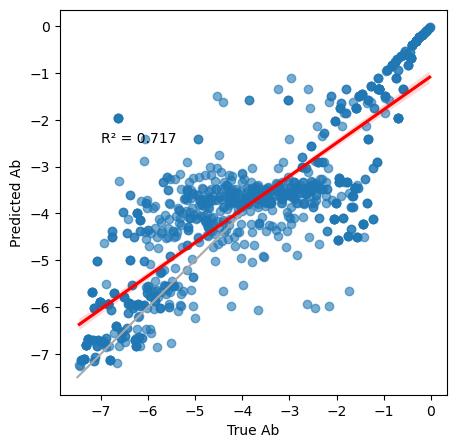

In [40]:
plt.figure(figsize=(5,5))

diag = np.linspace(-7.5,-4,1000)
plt.plot(diag, diag, '-', color='darkgrey')
sn.regplot(ytest, ypreds, line_kws=dict(color='red'), scatter_kws=dict(alpha=0.6))
#plt.xlim(-7.5,-4)
#plt.ylim(-7.5,-4)
plt.ylabel('Predicted Ab')
plt.xlabel('True Ab')
plt.annotate(f'R² = {round(r2_score(ytest, ypreds),3)}', (-7,-2.5))


***Distribucion Size + $\mu$ + $\beta$***

***Error predicción***

Utilizando las 3 variables como predictoras

In [46]:
X = data[['log(Size)','mu','log(beta)']]
X = (X - X.mean()) / X.std()

Xtest = X.iloc[ts_indexes]
ytest = y.iloc[ts_indexes]

Xtrain = X.iloc[tr_indexes]
ytrain = y.iloc[tr_indexes]

del X

In [47]:
ypreds = []
gamma = 1.06*10000**(-1/5)
gamma = 1/gamma

for i in range(len(Xtest)):
    Xdata = Xtest.iloc[i:i+1]
    kernel = rbf_kernel(Xdata, Xtrain, gamma=gamma)[0]
    norm = kernel.sum()
    ypred = (kernel*ytrain).sum() / norm
    ypreds.append(ypred)

ypreds = np.array(ypreds)

/home/mmartinez/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(-7, -2.5, 'R² = 0.966')

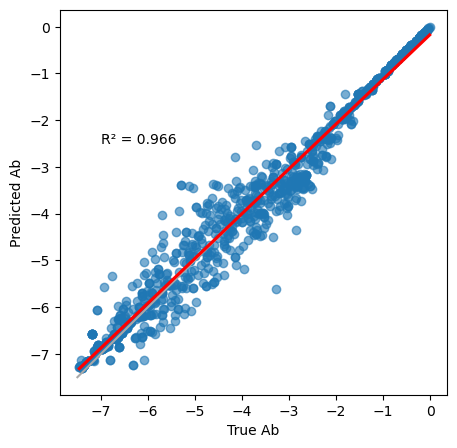

In [50]:
plt.figure(figsize=(5,5))

diag = np.linspace(-7.5,-4,1000)
plt.plot(diag, diag, '-', color='darkgrey')
sn.regplot(ytest, ypreds, line_kws=dict(color='red'), scatter_kws=dict(alpha=0.6))
plt.ylabel('Predicted Ab')
plt.xlabel('True Ab')
plt.annotate(f'R² = {round(r2_score(ytest, ypreds),3)}', (-7,-2.5))


## División de datos

***Out-of Sample (OOS)***

All networks for a few betas that won't be included in training at all.

In [ ]:
oos = data.loc[data['beta'].isin([0.001,0.01,0.63096,6.3096]), 
               ['NRed','log(Ab)','log(beta)','log(Size)','mu','Lambda1','Lambda2','Gr_Medio','H']]
oos.to_csv('../data/Networld_N200_TMax10000/OOS_MEAS_BP.csv', index=False)

***Training (TRN) and Test (TST)***

In [ ]:
insample = data.loc[~ data['beta'].isin([0.001,0.01,0.63096,6.3096]), 
               ['NRed','log(Ab)','log(beta)','log(Size)','mu','Lambda1','Lambda2','Gr_Medio','H']]

train, test = train_test_split(insample, test_size=0.2)
train.to_csv('../data/Networld_N200_TMax10000/TRN_MEAS_BP.csv', index=False)
test.to_csv('../data/Networld_N200_TMax10000/TST_MEAS_BP.csv', index=False)

## Entrenamiento modelos

***Carga de Datos***

Datos entrenamiento

In [3]:
Xtr = pd.read_csv('../data/Networld_N200_TMax10000/TRN_MEAS_BP.csv')
nred_tr = Xtr['NRed']
ytr = Xtr['log(Ab)']
del Xtr['NRed'], Xtr['log(Ab)']

Muestra uniforme de abundancias para el gráfico de correlación entre Ab predicha y real

In [4]:
abmin, abmax = ytr.min(),ytr.max()

abs = np.random.uniform(low=abmin, high=abmax, size=(1000,1))

indexes = []
for ab in abs:
    indexes.append(np.argmin((ytr - ab).abs()))

Conjunto de indices para división por CV

In [5]:
kf_idx = [idx_pair for idx_pair in KFold(n_splits=5).split(Xtr, ytr)]

print('Fold 1 - Train Index: ', kf_idx[0][0])
print('Fold 1 - Test Index: ', kf_idx[0][1])

Fold 1 - Train Index:  [160858 160859 160860 ... 804284 804285 804286]
Fold 1 - Test Index:  [     0      1      2 ... 160855 160856 160857]


***Peso de Ejemplos***

Los ejemplos se pesan según la inversa de la densidad de abundancia para compensar el desequilibrio de abundancia

In [4]:
kde = gaussian_kde(ytr)
y_uniq = np.unique(ytr)
wt_uniq = 1 / kde(y_uniq)

replacement_table = { y:wt for y,wt in zip(y_uniq, wt_uniq) }

wt = ytr.replace(replacement_table)
np.savetxt('../data/Networld_N200_TMax10000/TRN_sample_weights_BP.csv', wt, delimiter=',')

In [6]:
wt = np.loadtxt('../data/Networld_N200_TMax10000/TRN_sample_weights_BP.csv', delimiter=',')

### Regresión Lineal Lasso

***Primera Prueba***

Pequeña prueba para verificar que la pipe, el Lasso y los pesos de los ejemplos funcionan correctamente

In [6]:
pipe = Pipeline([('scaler', StandardScaler()), 
                ('lr', Lasso(alpha=1e-3))])

pipe.fit(Xtr, ytr, lr__sample_weight=wt)
print('Coeficientes Lasso: ', pipe['lr'].coef_)

yp = pipe.predict(Xtr)
print('MSE (unweighted): ', round(mean_squared_error(yp, ytr), 3))
print('MSE (weighted): ', round(mean_squared_error(yp, ytr, sample_weight=wt), 3))

Coeficientes Lasso:  [ 0.20407752 -0.64684755  0.1092551   0.09642396 -0.17785481 -0.4537915
  0.15229161]
MSE (unweighted):  1.053
MSE (weighted):  0.84


Text(-7, -2.5, 'R² = 0.762')

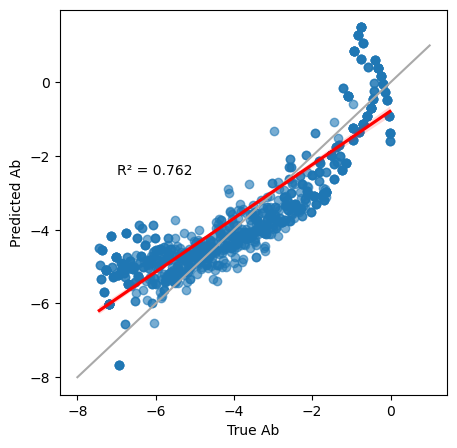

In [7]:
ytrs, yps = ytr.iloc[indexes], yp[indexes]

plt.figure(figsize=(5,5))

diag = np.linspace(-8,1,1000)
plt.plot(diag, diag, '-', color='darkgrey')
sn.regplot(x=ytrs, y=yps, line_kws=dict(color='red'), scatter_kws=dict(alpha=0.6))
plt.ylabel('Predicted Ab')
plt.xlabel('True Ab')
plt.annotate(f'R² = {round(r2_score(ytrs, yps),3)}', (-7,-2.5))

***Selección hiperparámetros***

Lasso solo tiene el hiperparámetro $\alpha$ que controla la fuerza de la regularización. Cuanto más alto con una score similar mejor porque damos una buena predicción con menos información (/usando menos variables)

Se valora el score para cada 

In [9]:
cv_results = []

In [18]:
#alpha_grid = [1e-4, 1e-2, 1, 1e2, 1e3, 1e4]
alpha_grid = [10**-3.5, 10**-3, 10**-2.5, 10**-1.5, 10**-1, 10**-0.5, 10**0.5]

cv_res = []
for alpha in alpha_grid:
    pipe = Pipeline([('scaler', StandardScaler()), 
                        ('lr', Lasso(alpha=alpha))])
    scores = []
    for (fit_index, val_index) in kf_idx:
        Xfit = Xtr.iloc[fit_index]
        yfit = ytr.iloc[fit_index]
        wtfit = wt[fit_index]
        pipe.fit(Xfit, yfit, lr__sample_weight=wtfit)

        Xval = Xtr.iloc[val_index]
        yval = ytr.iloc[val_index]
        wtval = wt[val_index]
        yp = pipe.predict(Xval)
        scores.append( mean_squared_error(yval, yp, sample_weight=wtval) )

    mean_score = np.mean(scores)
    std_score = np.std(scores)
    cv_res.append({'alpha': alpha, 'mean_score': mean_score, 'std_score': std_score})

    print(f'Alpha = {alpha}  -  Mean Score: {mean_score}')

cv_results.append(pd.DataFrame(cv_res))

Alpha = 0.00031622776601683794  -  Mean Score: 0.8670329582256058
Alpha = 0.001  -  Mean Score: 0.8669577705538855
Alpha = 0.0031622776601683794  -  Mean Score: 0.8661751730553542
Alpha = 0.03162277660168379  -  Mean Score: 0.8681103265474786
Alpha = 0.1  -  Mean Score: 0.8757069725379913
Alpha = 0.31622776601683794  -  Mean Score: 0.9723694916036226
Alpha = 3.1622776601683795  -  Mean Score: 3.234526425404172


In [21]:
cv_results = pd.concat(cv_results).sort_values(by='alpha')
cv_results

,alpha,mean_score,std_score
0,0.000100,0.867077,0.118855
0,0.000316,0.867033,0.118954
1,0.001000,0.866958,0.119266
2,0.003162,0.866175,0.121294
1,0.010000,0.866008,0.127265
3,0.031623,0.868110,0.134099
4,0.100000,0.875707,0.132535
5,0.316228,0.972369,0.146170
2,1.000000,1.479540,0.159016
6,3.162278,3.234526,0.368696


Text(0, 0.5, 'MSE (weighted)')

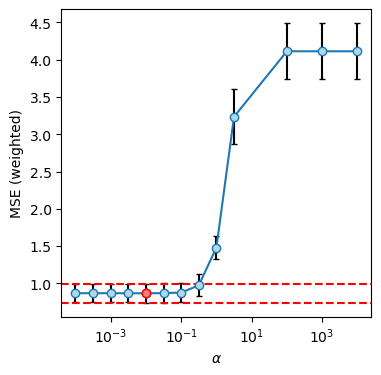

In [45]:
cv_results.plot(x='alpha', y='mean_score', yerr='std_score', 
            marker='o', markerfacecolor='lightblue', ecolor='black', capsize=2, 
            legend=False, figsize=(4,4))

idx_best = np.argmin(cv_results['mean_score'])
best_alpha = cv_results.iloc[idx_best]['alpha']
best_score = cv_results.iloc[idx_best]['mean_score']
best_std = cv_results.iloc[idx_best]['std_score']
plt.plot([best_alpha, best_alpha],[best_score, best_score], 'o', markerfacecolor='lightcoral', markeredgecolor='red', zorder=3)
plt.axhline(best_score + best_std, ls='--', color='red')
plt.axhline(best_score - best_std, ls='--', color='red')

plt.xscale('log')
plt.xlabel(r'$\alpha$')
plt.ylabel('MSE (weighted)')

In [6]:
lasso_safe = Pipeline([('scaler', StandardScaler()), 
                      ('lr', Lasso(alpha=0.1))]).fit(Xtr, ytr, lr__sample_weight=wt)
lasso_risky = Pipeline([('scaler', StandardScaler()), 
                      ('lr', Lasso(alpha=10**-0.5))]).fit(Xtr, ytr, lr__sample_weight=wt)

yp_safe = lasso_safe.predict(Xtr)
yp_risky = lasso_risky.predict(Xtr)

In [7]:
print('Coefs of safer model: ', lasso_safe['lr'].coef_, lasso_safe['lr'].intercept_)
print('RMSE of safer model: ', round( np.sqrt(mean_squared_error(ytr, yp_safe, sample_weight=wt)) ,3))
print('Coefs of risky model: ', lasso_risky['lr'].coef_, lasso_risky['lr'].intercept_)
print('RMSE of risky model: ', round( np.sqrt(mean_squared_error(ytr, yp_risky, sample_weight=wt)) ,3))

Coefs of safer model:  [ 0.17602092 -0.62552237  0.07486373 -0.         -0.11899525 -0.23720989
 -0.        ] -5.904596688971008
RMSE of safer model:  0.927
Coefs of risky model:  [ 0.11809423 -0.64438287  0.04566213 -0.         -0.03511244 -0.10959488
 -0.06323083] -5.6942447175541755
RMSE of risky model:  0.975


Text(0.5, 1.0, 'Modelo lineal')

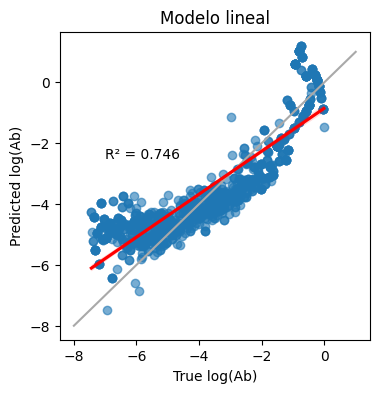

In [11]:
ytrs = ytr.iloc[indexes]
yps_safe = yp_safe[indexes]
yps_risky = yp_risky[indexes]

plt.figure(figsize=(4,4))
diag = np.linspace(-8,1,1000)
plt.plot(diag, diag, '-', color='darkgrey')
sn.regplot(x=ytrs, y=yps_safe, line_kws=dict(color='red'), scatter_kws=dict(alpha=0.6))
plt.ylabel('Predicted log(Ab)')
plt.xlabel('True log(Ab)')
plt.annotate(f'R² = {round(r2_score(ytrs, yps_safe),3)}', (-7,-2.5))
plt.title('Modelo lineal')

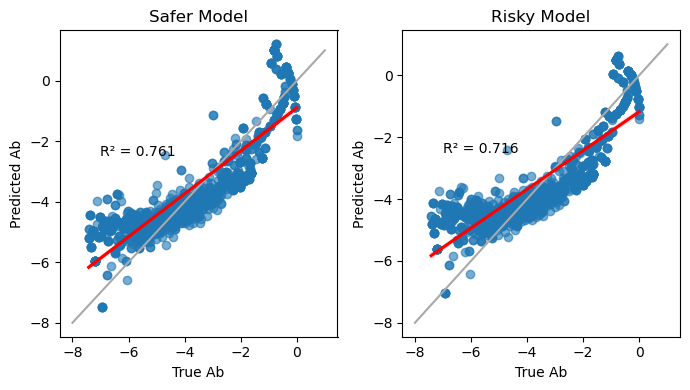

In [9]:
ytrs = ytr.iloc[indexes]
yps_safe = yp_safe[indexes]
yps_risky = yp_risky[indexes]

fig, [ax0,ax1] = plt.subplots(1,2,figsize=(7,4))
diag = np.linspace(-8,1,1000)

ax0.plot(diag, diag, '-', color='darkgrey')
sn.regplot(x=ytrs, y=yps_safe, line_kws=dict(color='red'), scatter_kws=dict(alpha=0.6), ax=ax0)
ax0.set_ylabel('Predicted Ab')
ax0.set_xlabel('True Ab')
ax0.annotate(f'R² = {round(r2_score(ytrs, yps_safe),3)}', (-7,-2.5))
ax0.set_title('Safer Model')

ax1.plot(diag, diag, '-', color='darkgrey')
sn.regplot(x=ytrs, y=yps_risky, line_kws=dict(color='red'), scatter_kws=dict(alpha=0.6), ax=ax1)
ax1.set_ylabel('Predicted Ab')
ax1.set_xlabel('True Ab')
ax1.annotate(f'R² = {round(r2_score(ytrs, yps_risky),3)}', (-7,-2.5))
ax1.set_title('Risky Model')

fig.tight_layout()

***Modelo explicativo (max. sparse)***

In [19]:
cv_results = []

In [ ]:
alpha_grid = 10**np.arange(-4,1.1,0.5)

cv_res = []
for alpha in alpha_grid:
    pipe = Pipeline([("selector", ColumnTransformer([
                        ("selector", "passthrough", ['log(beta)','log(Size)','Gr_Medio'])], remainder="drop")),
                    ('scaler', StandardScaler()), 
                    ('lr', Lasso(alpha=alpha))])
    scores = []
    for (fit_index, val_index) in kf_idx:
        Xfit = Xtr.iloc[fit_index]
        yfit = ytr.iloc[fit_index]
        wtfit = wt[fit_index]
        pipe.fit(Xfit, yfit, lr__sample_weight=wtfit)

        Xval = Xtr.iloc[val_index]
        yval = ytr.iloc[val_index]
        wtval = wt[val_index]
        yp = pipe.predict(Xval)
        scores.append( mean_squared_error(yval, yp, sample_weight=wtval) )

    mean_score = np.mean(scores)
    std_score = np.std(scores)
    cv_res.append({'alpha': alpha, 'mean_score': mean_score, 'std_score': std_score})

    print(f'Alpha = {alpha}  -  Mean Score: {mean_score}')

cv_results.append(pd.DataFrame(cv_res))

Text(0, 0.5, 'MSE (weighted)')

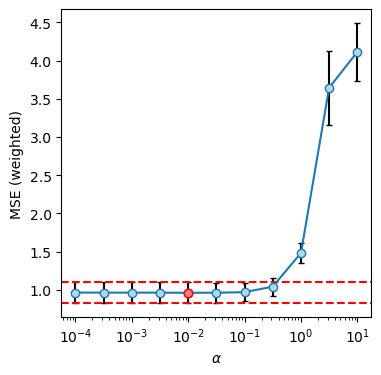

In [22]:
cv_results = pd.concat(cv_results)

cv_results.plot(x='alpha', y='mean_score', yerr='std_score', 
            marker='o', markerfacecolor='lightblue', ecolor='black', capsize=2, 
            legend=False, figsize=(4,4))

idx_best = np.argmin(cv_results['mean_score'])
best_alpha = cv_results.iloc[idx_best]['alpha']
best_score = cv_results.iloc[idx_best]['mean_score']
best_std = cv_results.iloc[idx_best]['std_score']
plt.plot([best_alpha, best_alpha],[best_score, best_score], 'o', markerfacecolor='lightcoral', markeredgecolor='red', zorder=3)
plt.axhline(best_score + best_std, ls='--', color='red')
plt.axhline(best_score - best_std, ls='--', color='red')

plt.xscale('log')
plt.xlabel(r'$\alpha$')
plt.ylabel('MSE (weighted)')

In [24]:
minimal_best = Pipeline([("selector", ColumnTransformer([
                        ("selector", "passthrough", ['log(beta)','log(Size)','Gr_Medio'])], remainder="drop")),
                    ('scaler', StandardScaler()), 
                    ('lr', Lasso(alpha=1e-2))]).fit(Xtr, ytr, lr__sample_weight=wt)
minimal_risky = Pipeline([("selector", ColumnTransformer([
                        ("selector", "passthrough", ['log(beta)','log(Size)','Gr_Medio'])], remainder="drop")),
                    ('scaler', StandardScaler()), 
                    ('lr', Lasso(alpha=10**-0.5))]).fit(Xtr, ytr, lr__sample_weight=wt)

yp_best = minimal_best.predict(Xtr)
yp_risky = minimal_risky.predict(Xtr)

In [26]:
print('Coefs of safer model: ', minimal_best['lr'].coef_, minimal_best['lr'].intercept_)
print('RMSE of safer model: ', round( np.sqrt(mean_squared_error(ytr, yp_best, sample_weight=wt)) ,3))
print('Coefs of risky model: ', minimal_risky['lr'].coef_, minimal_risky['lr'].intercept_)
print('RMSE of risky model: ', round( np.sqrt(mean_squared_error(ytr, yp_risky, sample_weight=wt)) ,3))

Coefs of safer model:  [ 0.18485705 -1.02672016 -0.        ] -5.979483842758837
MSE of safer model:  0.973
Coefs of risky model:  [ 0.1047233  -0.86216036 -0.00244532] -5.712268625341104
MSE of risky model:  1.013


Text(-7, -2.5, 'R² = 0.734')

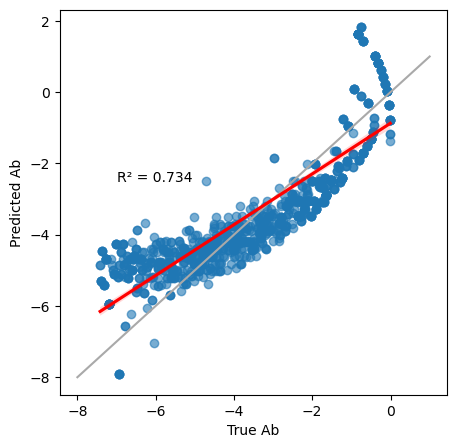

In [27]:
ytrs, yps = ytr.iloc[indexes], yp_best[indexes]

plt.figure(figsize=(5,5))

diag = np.linspace(-8,1,1000)
plt.plot(diag, diag, '-', color='darkgrey')
sn.regplot(x=ytrs, y=yps, line_kws=dict(color='red'), scatter_kws=dict(alpha=0.6))
plt.ylabel('Predicted Ab')
plt.xlabel('True Ab')
plt.annotate(f'R² = {round(r2_score(ytrs, yps),3)}', (-7,-2.5))

***Modelo con interacciones***

In [28]:
cv_results = []

In [58]:
alpha_grid = 10**np.arange(-4,1.1,0.5)

cv_res = []
for alpha in alpha_grid:
    pipe = Pipeline([("selector", ColumnTransformer([
                        ("selector", "passthrough", ['log(beta)','log(Size)','mu','Gr_Medio'])], remainder="drop")),
                    ('interact', FunctionTransformer(func=lambda x: np.concatenate([x, 
                                                                                    (x[:,0]*x[:,1])[:,None],
                                                                                    (x[:,0]*x[:,2])[:,None],
                                                                                    (x[:,0]*x[:,3])[:,None],
                                                                                    (x[:,2]*x[:,1])[:,None],
                                                                                    (x[:,2]*x[:,3])[:,None]], axis=1))),
                    ('scaler', StandardScaler()), 
                    ('lr', Lasso(alpha=alpha))])
    scores = []
    for (fit_index, val_index) in kf_idx:
        Xfit = Xtr.iloc[fit_index]
        yfit = ytr.iloc[fit_index]
        wtfit = wt[fit_index]
        pipe.fit(Xfit, yfit, lr__sample_weight=wtfit)

        Xval = Xtr.iloc[val_index]
        yval = ytr.iloc[val_index]
        wtval = wt[val_index]
        yp = pipe.predict(Xval)
        scores.append( mean_squared_error(yval, yp, sample_weight=wtval) )

    mean_score = np.mean(scores)
    std_score = np.std(scores)
    cv_res.append({'alpha': alpha, 'mean_score': mean_score, 'std_score': std_score})

    print(f'Alpha = {alpha}  -  Mean Score: {mean_score}')

cv_results.append(pd.DataFrame(cv_res))

/home/mmartinez/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.764e+04, tolerance: 2.568e+02
  model = cd_fast.enet_coordinate_descent(
/home/mmartinez/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.501e+04, tolerance: 2.625e+02
  model = cd_fast.enet_coordinate_descent(
/home/mmartinez/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation.

Alpha = 0.0001  -  Mean Score: 0.6953462838916924


/home/mmartinez/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.178e+04, tolerance: 2.568e+02
  model = cd_fast.enet_coordinate_descent(
/home/mmartinez/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.403e+04, tolerance: 2.625e+02
  model = cd_fast.enet_coordinate_descent(
/home/mmartinez/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation.

Alpha = 0.00031622776601683794  -  Mean Score: 0.6953392721154262


/home/mmartinez/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.302e+03, tolerance: 2.568e+02
  model = cd_fast.enet_coordinate_descent(
/home/mmartinez/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.413e+02, tolerance: 2.625e+02
  model = cd_fast.enet_coordinate_descent(
/home/mmartinez/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation.

Alpha = 0.001  -  Mean Score: 0.6957952361703098


/home/mmartinez/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.842e+02, tolerance: 2.568e+02
  model = cd_fast.enet_coordinate_descent(
/home/mmartinez/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.737e+02, tolerance: 2.693e+02
  model = cd_fast.enet_coordinate_descent(
/home/mmartinez/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation.

Alpha = 0.0031622776601683794  -  Mean Score: 0.7019316967954402
Alpha = 0.01  -  Mean Score: 0.7338407931830938
Alpha = 0.03162277660168379  -  Mean Score: 0.7779309727261254
Alpha = 0.1  -  Mean Score: 0.7961229709654001
Alpha = 0.31622776601683794  -  Mean Score: 0.9047903062906965
Alpha = 1.0  -  Mean Score: 1.4682810441580465
Alpha = 3.1622776601683795  -  Mean Score: 3.741162990137581
Alpha = 10.0  -  Mean Score: 4.1130607049254495


Text(0, 0.5, 'MSE (weighted)')

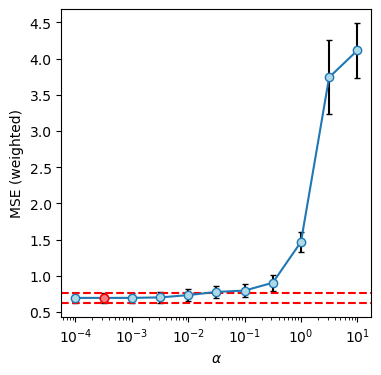

In [59]:
cv_results = pd.concat(cv_results)

cv_results.plot(x='alpha', y='mean_score', yerr='std_score', 
            marker='o', markerfacecolor='lightblue', ecolor='black', capsize=2, 
            legend=False, figsize=(4,4))

idx_best = np.argmin(cv_results['mean_score'])
best_alpha = cv_results.iloc[idx_best]['alpha']
best_score = cv_results.iloc[idx_best]['mean_score']
best_std = cv_results.iloc[idx_best]['std_score']
plt.plot([best_alpha, best_alpha],[best_score, best_score], 'o', markerfacecolor='lightcoral', markeredgecolor='red', zorder=3)
plt.axhline(best_score + best_std, ls='--', color='red')
plt.axhline(best_score - best_std, ls='--', color='red')

plt.xscale('log')
plt.xlabel(r'$\alpha$')
plt.ylabel('MSE (weighted)')

El mejor modelo estaría en $\alpha$ = 0.01, en este caso no parece haber varias opciones demasiado contestadas, así que solo 1

In [12]:
int_model = Pipeline([("selector", ColumnTransformer([
                        ("selector", "passthrough", ['log(beta)','log(Size)','mu','Gr_Medio'])], remainder="drop")),
                    ('interact', FunctionTransformer(func=lambda x: np.concatenate([x, 
                                                                                    (x[:,0]*x[:,1])[:,None],
                                                                                    (x[:,0]*x[:,2])[:,None],
                                                                                    (x[:,0]*x[:,3])[:,None],
                                                                                    (x[:,2]*x[:,1])[:,None],
                                                                                    (x[:,2]*x[:,3])[:,None]], axis=1))),
                    ('scaler', StandardScaler()), 
                    ('lr', Lasso(alpha=0.01))]).fit(Xtr, ytr, lr__sample_weight=wt)

yp = int_model.predict(Xtr)
print('Coefs of interaction model: ', int_model['lr'].coef_, int_model['lr'].intercept_)
print('RMSE of interaction model: ', round( np.sqrt(mean_squared_error(ytr, yp, sample_weight=wt)) ,3))

Coefs of interaction model:  [ 0.07911096 -1.2324415   0.16029642  0.18474567  0.40338767 -0.00507392
  0.          0.56147899 -0.69195189] -5.799304610662878
RMSE of interaction model:  0.844


Text(-7, -2.5, 'R² = 0.84')

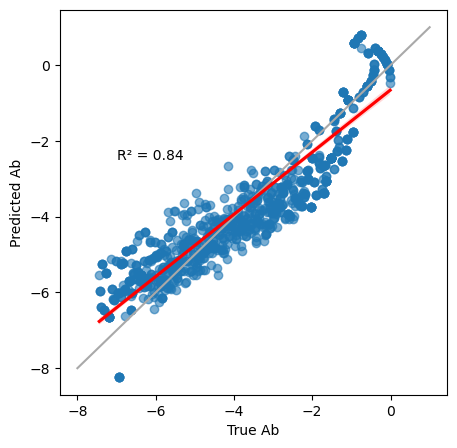

In [16]:
ytrs, yps = ytr.iloc[indexes], yp[indexes]

plt.figure(figsize=(5,5))

diag = np.linspace(-8,1,1000)
plt.plot(diag, diag, '-', color='darkgrey')
sn.regplot(x=ytrs, y=yps, line_kws=dict(color='red'), scatter_kws=dict(alpha=0.6))
plt.ylabel('Predicted Ab')
plt.xlabel('True Ab')
plt.annotate(f'R² = {round(r2_score(ytrs, yps),3)}', (-7,-2.5))

In [70]:
cv_results = []

In [14]:
alpha_grid = 10**np.arange(-4,1.1,0.5)

cv_res = []
for alpha in alpha_grid:
    pipe = Pipeline([("st_selector", ColumnTransformer([
                        ("selector", "passthrough", ['log(beta)','log(Size)','mu','Gr_Medio'])], remainder="drop")),
                    ('interact', FunctionTransformer(func=lambda x: np.concatenate([x, 
                                                                                    (x[:,0]*x[:,1])[:,None],
                                                                                    (x[:,2]*x[:,1])[:,None],
                                                                                    (x[:,2]*x[:,3])[:,None]], axis=1))),
                    ("end_selector", ColumnTransformer([
                        ("selector", "passthrough", [1,4,5,6])], remainder="drop")),
                    ('scaler', StandardScaler()), 
                    ('lr', Lasso(alpha=alpha))])
    scores = []
    for (fit_index, val_index) in kf_idx:
        Xfit = Xtr.iloc[fit_index]
        yfit = ytr.iloc[fit_index]
        wtfit = wt[fit_index]
        pipe.fit(Xfit, yfit, lr__sample_weight=wtfit)

        Xval = Xtr.iloc[val_index]
        yval = ytr.iloc[val_index]
        wtval = wt[val_index]
        yp = pipe.predict(Xval)
        scores.append( mean_squared_error(yval, yp, sample_weight=wtval) )

    mean_score = np.mean(scores)
    std_score = np.std(scores)
    cv_res.append({'alpha': alpha, 'mean_score': mean_score, 'std_score': std_score})

    print(f'Alpha = {alpha}  -  Mean Score: {mean_score}')

cv_results.append(pd.DataFrame(cv_res))

KeyboardInterrupt: 

Text(0, 0.5, 'MSE (weighted)')

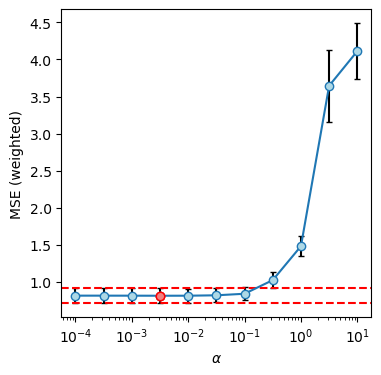

In [72]:
cv_results = pd.concat(cv_results)

cv_results.plot(x='alpha', y='mean_score', yerr='std_score', 
            marker='o', markerfacecolor='lightblue', ecolor='black', capsize=2, 
            legend=False, figsize=(4,4))

idx_best = np.argmin(cv_results['mean_score'])
best_alpha = cv_results.iloc[idx_best]['alpha']
best_score = cv_results.iloc[idx_best]['mean_score']
best_std = cv_results.iloc[idx_best]['std_score']
plt.plot([best_alpha, best_alpha],[best_score, best_score], 'o', markerfacecolor='lightcoral', markeredgecolor='red', zorder=3)
plt.axhline(best_score + best_std, ls='--', color='red')
plt.axhline(best_score - best_std, ls='--', color='red')

plt.xscale('log')
plt.xlabel(r'$\alpha$')
plt.ylabel('MSE (weighted)')

In [13]:
int_model = Pipeline([("st_selector", ColumnTransformer([
                        ("selector", "passthrough", ['log(beta)','log(Size)','mu','Gr_Medio'])], remainder="drop")),
                    ('interact', FunctionTransformer(func=lambda x: np.concatenate([x, 
                                                                                    (x[:,0]*x[:,1])[:,None],
                                                                                    (x[:,2]*x[:,1])[:,None],
                                                                                    (x[:,2]*x[:,3])[:,None]], axis=1))),
                    ("end_selector", ColumnTransformer([
                        ("selector", "passthrough", [1,4,5,6])], remainder="drop")),
                    ('scaler', StandardScaler()), 
                    ('lr', Lasso(alpha=0.1))]).fit(Xtr, ytr, lr__sample_weight=wt)

yp = int_model.predict(Xtr)
print('Coefs of interaction model: ', int_model['lr'].coef_, int_model['lr'].intercept_)
print('RMSE of interaction model: ', round( np.sqrt(mean_squared_error(ytr, yp, sample_weight=wt)) ,3))

Coefs of interaction model:  [-0.95358982  0.41220744  0.          0.10055051] -5.633168939535294
RMSE of interaction model:  0.91


Text(0.5, 1.0, 'Modelo lineal interacciones')

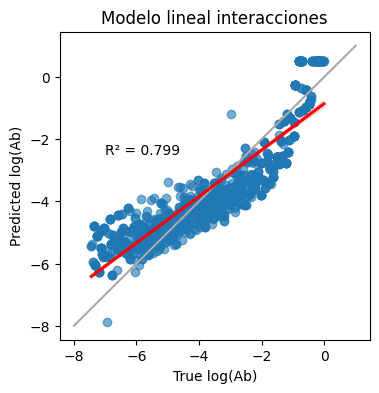

In [17]:
ytrs = ytr.iloc[indexes]
yps = yp[indexes]

plt.figure(figsize=(4,4))
diag = np.linspace(-8,1,1000)
plt.plot(diag, diag, '-', color='darkgrey')
sn.regplot(x=ytrs, y=yps, line_kws=dict(color='red'), scatter_kws=dict(alpha=0.6))
plt.ylabel('Predicted log(Ab)')
plt.xlabel('True log(Ab)')
plt.annotate(f'R² = {round(r2_score(ytrs, yps),3)}', (-7,-2.5))
plt.title('Modelo lineal interacciones')

Text(-7, -2.5, 'R² = 0.801')

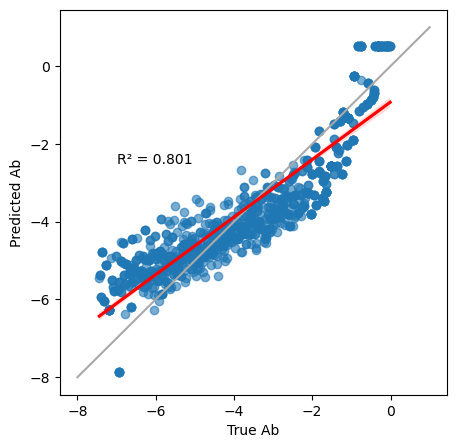

In [13]:
ytrs, yps = ytr.iloc[indexes], yp[indexes]

plt.figure(figsize=(5,5))

diag = np.linspace(-8,1,1000)
plt.plot(diag, diag, '-', color='darkgrey')
sn.regplot(x=ytrs, y=yps, line_kws=dict(color='red'), scatter_kws=dict(alpha=0.6))
plt.ylabel('Predicted Ab')
plt.xlabel('True Ab')
plt.annotate(f'R² = {round(r2_score(ytrs, yps),3)}', (-7,-2.5))

Pequeño testeo con un BayesianRidge que estima la regularización de los datos en vez de por CV y saca resultados un poco mejores (aunque los coefs son bastante parecidos creo)

In [7]:
int_model = Pipeline([("st_selector", ColumnTransformer([
                        ("selector", "passthrough", ['log(beta)','log(Size)','mu','Gr_Medio'])], remainder="drop")),
                    ('interact', FunctionTransformer(func=lambda x: np.concatenate([x, 
                                                                                    (x[:,0]*x[:,1])[:,None],
                                                                                    (x[:,2]*x[:,1])[:,None],
                                                                                    (x[:,2]*x[:,3])[:,None]], axis=1))),
                    ("end_selector", ColumnTransformer([
                        ("selector", "passthrough", [1,4,5,6])], remainder="drop")),
                    ('scaler', StandardScaler()), 
                    ('br', BayesianRidge())]).fit(Xtr, ytr, br__sample_weight=wt)

yp = int_model.predict(Xtr)
print('Coefs of interaction model: ', int_model['br'].coef_, int_model['br'].intercept_)
print('RMSE of interaction model: ', round( np.sqrt(mean_squared_error(ytr, yp, sample_weight=wt)) ,3))

Coefs of interaction model:  [-1.06549312  0.51306208  0.23956609 -0.00893834] -5.698003104213882
RMSE of interaction model:  0.895


Text(-7, -2.5, 'R² = 0.813')

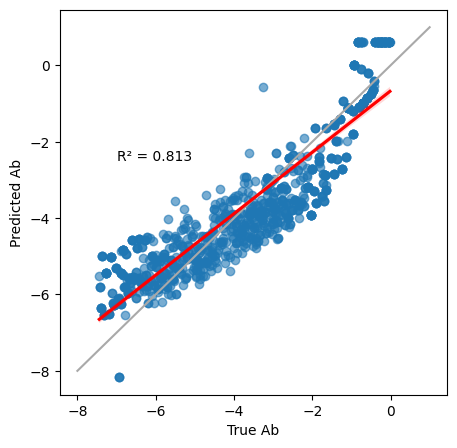

In [8]:
ytrs, yps = ytr.iloc[indexes], yp[indexes]

plt.figure(figsize=(5,5))

diag = np.linspace(-8,1,1000)
plt.plot(diag, diag, '-', color='darkgrey')
sn.regplot(x=ytrs, y=yps, line_kws=dict(color='red'), scatter_kws=dict(alpha=0.6))
plt.ylabel('Predicted Ab')
plt.xlabel('True Ab')
plt.annotate(f'R² = {round(r2_score(ytrs, yps),3)}', (-7,-2.5))

### Regresión por modelos aditivos

In [7]:
Xtr_gam = Xtr
Xtr_gam.rename(columns={'log(beta)':'logbeta','log(Size)':'logsize'}, inplace=True)
Xtr_gam['logab'] = ytr

x_spline = Xtr_gam[['logbeta','logsize','mu','Gr_Medio']]
bs = BSplines(x_spline, df=[5,5,5,5], degree=[3,3,3,3])
reg = GLMGam.from_formula('logab ~ logbeta + logsize + mu + Gr_Medio', 
                          data=Xtr_gam, smoother=bs).fit()

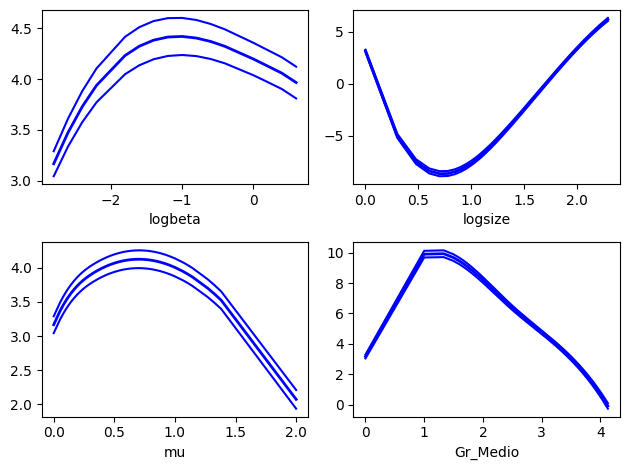

In [12]:
fig, axs = plt.subplots(2,2)
axs = [ax for axlist in axs for ax in axlist]

for i in range(4):
    reg.plot_partial(i, ax=axs[i])
    

fig.tight_layout()

In [16]:
yp = reg.predict()
print('RMSE of GAM: ', round( np.sqrt(mean_squared_error(ytr, yp, sample_weight=wt)) ,3))

RMSE of GAM:  1.788


Text(-7, -2.5, 'R² = 0.287')

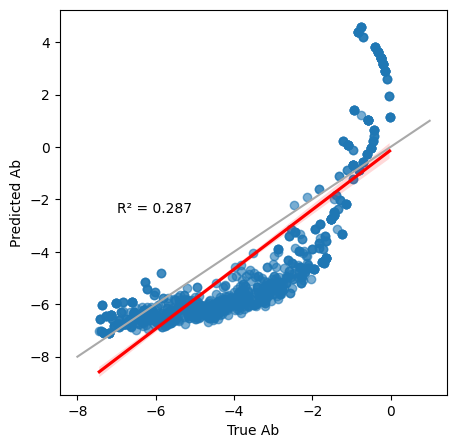

In [17]:
ytrs, yps = ytr.iloc[indexes], yp[indexes]

plt.figure(figsize=(5,5))

diag = np.linspace(-8,1,1000)
plt.plot(diag, diag, '-', color='darkgrey')
sn.regplot(x=ytrs, y=yps, line_kws=dict(color='red'), scatter_kws=dict(alpha=0.6))
plt.ylabel('Predicted Ab')
plt.xlabel('True Ab')
plt.annotate(f'R² = {round(r2_score(ytrs, yps),3)}', (-7,-2.5))

In [7]:
Xtr_gam = Xtr
del Xtr
Xtr_gam.rename(columns={'log(beta)':'logbeta','log(Size)':'logsize'}, inplace=True)
Xtr_gam['logab'] = ytr
Xtr_gam['beta_size'] = Xtr_gam['logbeta'] * Xtr_gam['logsize']

x_spline = Xtr_gam[['logbeta','logsize','mu','beta_size']]
bs = BSplines(x_spline, df=[5,5,5,5], degree=[3,3,3,3])
reg = GLMGam.from_formula('logab ~ logbeta + logsize + mu + beta_size', 
                          data=Xtr_gam, smoother=bs).fit()

In [8]:
yp = reg.predict()
print('RMSE of GAM: ', round( np.sqrt(mean_squared_error(ytr, yp, sample_weight=wt)) ,3))

RMSE of GAM:  2.154


Text(-7, -2.5, 'R² = -0.023')

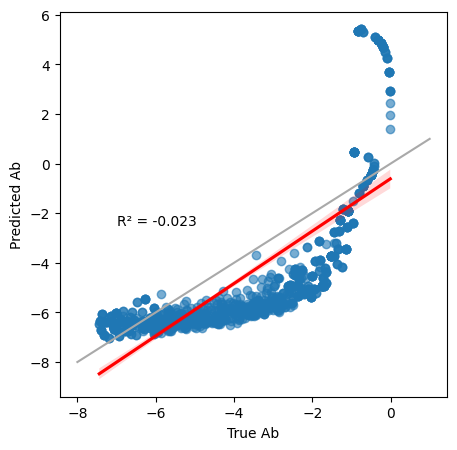

In [9]:
ytrs, yps = ytr.iloc[indexes], yp[indexes]

plt.figure(figsize=(5,5))

diag = np.linspace(-8,1,1000)
plt.plot(diag, diag, '-', color='darkgrey')
sn.regplot(x=ytrs, y=yps, line_kws=dict(color='red'), scatter_kws=dict(alpha=0.6))
plt.ylabel('Predicted Ab')
plt.xlabel('True Ab')
plt.annotate(f'R² = {round(r2_score(ytrs, yps),3)}', (-7,-2.5))

Ahora mismo no permite especificar class weights y/o no van a ser correctos así que por aqui parece que no merece mucho la pena seguir

### Regresión por SVM

No es una opción nada interesante porque tiene interpretabilidad mínima, pero considero que puede que merezca la pena probarlo para ver hasta que punto la predicción en sí sería viable

***Kernels RBF y Sigmoid***

In [7]:
cv_results = []

In [10]:
kernels = ['rbf', 'sigmoid']
C_grid = [1e3,1e2,1e1,1e0,1e-1,1e-2,1e-3]

cv_res = []
for kernel in kernels:
    for c in C_grid:
        pipe = Pipeline([('scaler', StandardScaler()), 
                            ('lr', SVR(kernel=kernel, C=c))])
        scores = []
        for (fit_index, val_index) in kf_idx:
            Xfit = Xtr.iloc[fit_index[:10000]]
            yfit = ytr.iloc[fit_index[:10000]]
            wtfit = wt[fit_index[:10000]]
            pipe.fit(Xfit, yfit, lr__sample_weight=wtfit)

            Xval = Xtr.iloc[val_index[:2000]]
            yval = ytr.iloc[val_index[:2000]]
            wtval = wt[val_index[:2000]]
            yp = pipe.predict(Xval)
            scores.append( mean_squared_error(yval, yp, sample_weight=wtval) )
            print('Fold completed')

        mean_score = np.mean(scores)
        std_score = np.std(scores)
        cv_res.append({'kernel': kernel, 'C':c, 'mean_score': mean_score, 'std_score': std_score})

        print(f'Kernel = {kernel}, C = {c}  -  Mean Score: {mean_score}')

cv_results.append(pd.DataFrame(cv_res))

Fold completed
Fold completed
Fold completed
Fold completed
Fold completed
Kernel = rbf, C = 1000.0  -  Mean Score: 6.7023809746763074
Fold completed
Fold completed
Fold completed
Fold completed
Fold completed
Kernel = rbf, C = 100.0  -  Mean Score: 3.292225515210658
Fold completed
Fold completed
Fold completed
Fold completed
Fold completed
Kernel = rbf, C = 10.0  -  Mean Score: 1.7885010755632844
Fold completed
Fold completed
Fold completed
Fold completed
Fold completed
Kernel = rbf, C = 1.0  -  Mean Score: 0.6910359163742429
Fold completed
Fold completed
Fold completed
Fold completed
Fold completed
Kernel = rbf, C = 0.1  -  Mean Score: 0.5154037016619105
Fold completed
Fold completed
Fold completed
Fold completed
Fold completed
Kernel = rbf, C = 0.01  -  Mean Score: 0.45253634023452793
Fold completed
Fold completed
Fold completed
Fold completed
Fold completed
Kernel = rbf, C = 0.001  -  Mean Score: 0.6235345959637881
Fold completed
Fold completed
Fold completed
Fold completed
Fold co

In [12]:
cv_results = pd.concat(cv_results).sort_values(by=['kernel','C'])
cv_results

,kernel,C,mean_score,std_score
6,rbf,0.001,6.235346e-01,3.054544e-01
5,rbf,0.010,4.525363e-01,2.414961e-01
4,rbf,0.100,5.154037e-01,2.619270e-01
3,rbf,1.000,6.910359e-01,5.813386e-01
2,rbf,10.000,1.788501e+00,2.011236e+00
1,rbf,100.000,3.292226e+00,3.210889e+00
0,rbf,1000.000,6.702381e+00,8.019823e+00
13,sigmoid,0.001,1.520804e+02,4.155054e+01
12,sigmoid,0.010,1.277160e+04,3.562889e+03
11,sigmoid,0.100,1.252916e+06,3.477295e+05


Text(0, 0.5, 'MSE (weighted)')

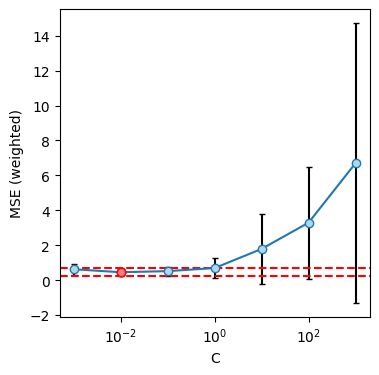

In [14]:
cv_results.loc[cv_results['kernel']=='rbf'].plot(x='C', y='mean_score', yerr='std_score', 
            marker='o', markerfacecolor='lightblue', ecolor='black', capsize=2, 
            legend=False, figsize=(4,4))

idx_best = np.argmin(cv_results['mean_score'])
best_alpha = cv_results.iloc[idx_best]['C']
best_score = cv_results.iloc[idx_best]['mean_score']
best_std = cv_results.iloc[idx_best]['std_score']
plt.plot([best_alpha, best_alpha],[best_score, best_score], 'o', markerfacecolor='lightcoral', markeredgecolor='red', zorder=3)
plt.axhline(best_score + best_std, ls='--', color='red')
plt.axhline(best_score - best_std, ls='--', color='red')

plt.xscale('log')
plt.xlabel(r'C')
plt.ylabel('MSE (weighted)')

In [10]:
svm = Pipeline([('scaler', StandardScaler()), 
                ('lr', SVR(kernel='rbf', C=0.1))]).fit(Xtr.iloc[:10000], ytr.iloc[:10000], lr__sample_weight=wt[:10000])

yp = svm.predict(Xtr.iloc[10000:20000])

In [19]:
print('RMSE of SVR model: ', round( np.sqrt(mean_squared_error(ytr.iloc[10000:20000], yp, sample_weight=wt[10000:20000])) ,3))

RMSE of SVR model:  1.208


***Kernel Polynomial***

In [7]:
cv_results = []

In [8]:
C_grid = [1e2,1e1,1e0,1e-1,1e-2]
deg_grid = [2,3,4]

cv_res = []
for deg in deg_grid:
    for c in C_grid:
        pipe = Pipeline([('scaler', StandardScaler()), 
                            ('lr', SVR(kernel='poly', degree=deg, C=c))])
        scores = []
        for (fit_index, val_index) in kf_idx:
            Xfit = Xtr.iloc[fit_index[:10000]]
            yfit = ytr.iloc[fit_index[:10000]]
            wtfit = wt[fit_index[:10000]]
            pipe.fit(Xfit, yfit, lr__sample_weight=wtfit)

            Xval = Xtr.iloc[val_index[:2000]]
            yval = ytr.iloc[val_index[:2000]]
            wtval = wt[val_index[:2000]]
            yp = pipe.predict(Xval)
            scores.append( mean_squared_error(yval, yp, sample_weight=wtval) )
            print('Fold completed')

        mean_score = np.mean(scores)
        std_score = np.std(scores)
        cv_res.append({'C': c, 'degree':deg, 'mean_score': mean_score, 'std_score': std_score})

        print(f'C = {c}, Degree = {deg}  -  Mean Score: {mean_score}')

cv_results.append(pd.DataFrame(cv_res))

Fold completed
Fold completed
Fold completed
Fold completed
Fold completed
C = 100.0, Degree = 2  -  Mean Score: 8.734061142000522
Fold completed
Fold completed
Fold completed
Fold completed
Fold completed
C = 10.0, Degree = 2  -  Mean Score: 8.746808351818235
Fold completed
Fold completed
Fold completed
Fold completed
Fold completed
C = 1.0, Degree = 2  -  Mean Score: 6.927673195323526
Fold completed
Fold completed
Fold completed
Fold completed
Fold completed
C = 0.1, Degree = 2  -  Mean Score: 4.77249399363051
Fold completed
Fold completed
Fold completed
Fold completed
Fold completed
C = 0.01, Degree = 2  -  Mean Score: 3.839081212169937


In [ ]:
cv_results = pd.concat(cv_results).sort_values(by=['C','degree'])
cv_results

,kernel,C,mean_score,std_score
6,rbf,0.001,6.235346e-01,3.054544e-01
5,rbf,0.010,4.525363e-01,2.414961e-01
4,rbf,0.100,5.154037e-01,2.619270e-01
3,rbf,1.000,6.910359e-01,5.813386e-01
2,rbf,10.000,1.788501e+00,2.011236e+00
1,rbf,100.000,3.292226e+00,3.210889e+00
0,rbf,1000.000,6.702381e+00,8.019823e+00
13,sigmoid,0.001,1.520804e+02,4.155054e+01
12,sigmoid,0.010,1.277160e+04,3.562889e+03
11,sigmoid,0.100,1.252916e+06,3.477295e+05


Text(0, 0.5, 'MSE (weighted)')

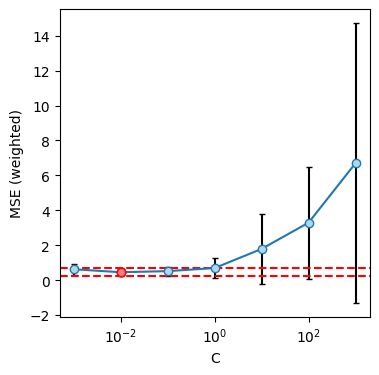

In [ ]:
cv_results.plot(x='degree', y='mean_score', yerr='std_score', 
            marker='o', markerfacecolor='lightblue', ecolor='black', capsize=2, 
            legend=False, figsize=(4,4))

idx_best = np.argmin(cv_results['mean_score'])
best_alpha = cv_results.iloc[idx_best]['degree']
best_score = cv_results.iloc[idx_best]['mean_score']
best_std = cv_results.iloc[idx_best]['std_score']
plt.plot([best_alpha, best_alpha],[best_score, best_score], 'o', markerfacecolor='lightcoral', markeredgecolor='red', zorder=3)
plt.axhline(best_score + best_std, ls='--', color='red')
plt.axhline(best_score - best_std, ls='--', color='red')

plt.xscale('log')
plt.xlabel('degree')
plt.ylabel('MSE (weighted)')